1. Selección del modelo


### Justificación:
- ResNet50 es conocido por su capacidad de manejar redes profundas sin problemas de degradación.
- VGG16 es simple y efectivo, con un buen equilibrio entre profundidad y rendimiento.

2. Preprocesamiento de imágenes y data augmentation
- [ImagePreparation.ipynb](ImagePreparation.ipynb)

In [1]:
from torchvision import models

# Selección de modelos
model1 = models.resnet50(pretrained=True)
model2 = models.vgg16(pretrained=True)



c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 30.9MB/s]
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: User

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir transformaciones para los datos
data_transforms = {
    'bilateral': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'raw': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'canny': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Cargar los datos
data_dir = 'dataset/augmented'
image_datasets = {x: datasets.ImageFolder(f'{data_dir}/{x}', data_transforms[x]) for x in ['bilateral', 'raw', 'canny']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['bilateral', 'raw', 'canny']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['bilateral', 'raw', 'canny']}
class_names = image_datasets['raw'].classes


# Función para entrenar el modelo
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for dataset in ['bilateral', 'raw', 'canny']:
                for inputs, labels in dataloaders[phase][dataset]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / sum(dataset_sizes[phase].values())
            epoch_acc = running_corrects.double() / sum(dataset_sizes[phase].values())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


# Función para evaluar el modelo
def evaluate_model(model, dataloaders, dataset_sizes):
    model.eval()
    all_preds = []
    all_labels = []

    for dataset in ['bilateral', 'raw', 'canny']:
        for inputs, labels in dataloaders['val'][dataset]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Configuración del dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Split the datasets into training and validation sets
train_datasets = {}
val_datasets = {}
for x in ['bilateral', 'raw', 'canny']:
    train_idx, val_idx = train_test_split(list(range(len(image_datasets[x]))), test_size=0.2, random_state=42)
    train_datasets[x] = torch.utils.data.Subset(image_datasets[x], train_idx)
    val_datasets[x] = torch.utils.data.Subset(image_datasets[x], val_idx)

# Update the dataloaders dictionary
dataloaders = {
    'train': {x: torch.utils.data.DataLoader(train_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['bilateral', 'raw', 'canny']},
    'val': {x: torch.utils.data.DataLoader(val_datasets[x], batch_size=32, shuffle=False, num_workers=4) for x in ['bilateral', 'raw', 'canny']}
}

dataset_sizes = {
    'train': {x: len(train_datasets[x]) for x in ['bilateral', 'raw', 'canny']},
    'val': {x: len(val_datasets[x]) for x in ['bilateral', 'raw', 'canny']}
}

# Definir los modelos a entrenar
models_to_train = {
    'resnet': models.resnet50(pretrained=True),
    'vgg': models.vgg16(pretrained=True)
}

for model_name, model in models_to_train.items():
    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'resnet':
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    elif model_name == 'vgg':
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters() if model_name == 'resnet' else model.classifier[6].parameters(), lr=0.001, momentum=0.9)

    for dataset in ['bilateral', 'raw', 'canny']:
        print(f'Training {model_name} on {dataset} dataset')
        model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes)
        torch.save(model.state_dict(), f'{model_name}_{dataset}.pth')
        #evaluate_model(model, dataloaders, dataset_sizes)

cuda:0


c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGEN

Training resnet on bilateral dataset
Epoch 0/24
----------
train Loss: 0.4585 Acc: 0.8041
val Loss: 1.6759 Acc: 0.7749
Epoch 1/24
----------
train Loss: 0.4025 Acc: 0.8220
val Loss: 2.3494 Acc: 0.4174
Epoch 2/24
----------
train Loss: 0.3784 Acc: 0.8343
val Loss: 3.0892 Acc: 0.4209
Epoch 3/24
----------
train Loss: 0.3654 Acc: 0.8424
val Loss: 2.0890 Acc: 0.4634
Epoch 4/24
----------
train Loss: 0.3566 Acc: 0.8449
val Loss: 5.2666 Acc: 0.4201
Epoch 5/24
----------
train Loss: 0.3505 Acc: 0.8499
val Loss: 5.0111 Acc: 0.4218
Epoch 6/24
----------
train Loss: 0.3453 Acc: 0.8503
val Loss: 5.1176 Acc: 0.4174
Epoch 7/24
----------
train Loss: 0.3426 Acc: 0.8515
val Loss: 1.4093 Acc: 0.5177
Epoch 8/24
----------
train Loss: 0.3375 Acc: 0.8554
val Loss: 2.9746 Acc: 0.4293
Epoch 9/24
----------
train Loss: 0.3366 Acc: 0.8551
val Loss: 3.9770 Acc: 0.4218
Epoch 10/24
----------
train Loss: 0.3286 Acc: 0.8558
val Loss: 2.6726 Acc: 0.4433
Epoch 11/24
----------
train Loss: 0.3240 Acc: 0.8599
val Lo

Training vgg on bilateral dataset
              precision    recall  f1-score   support

        test       0.45      0.80      0.57       522
       train       0.92      0.71      0.80      1761

    accuracy                           0.73      2283
   macro avg       0.68      0.75      0.69      2283
weighted avg       0.81      0.73      0.75      2283



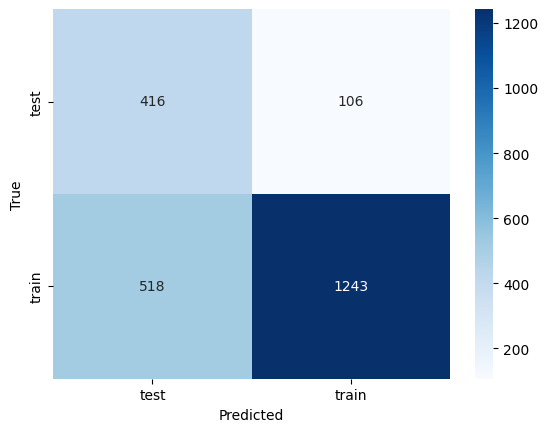

Training vgg on raw dataset
              precision    recall  f1-score   support

        test       0.45      0.80      0.57       522
       train       0.92      0.71      0.80      1761

    accuracy                           0.73      2283
   macro avg       0.68      0.75      0.69      2283
weighted avg       0.81      0.73      0.75      2283



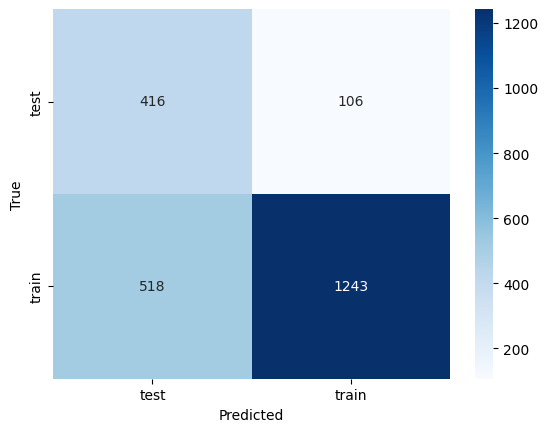

Training vgg on canny dataset
              precision    recall  f1-score   support

        test       0.45      0.80      0.57       522
       train       0.92      0.71      0.80      1761

    accuracy                           0.73      2283
   macro avg       0.68      0.75      0.69      2283
weighted avg       0.81      0.73      0.75      2283



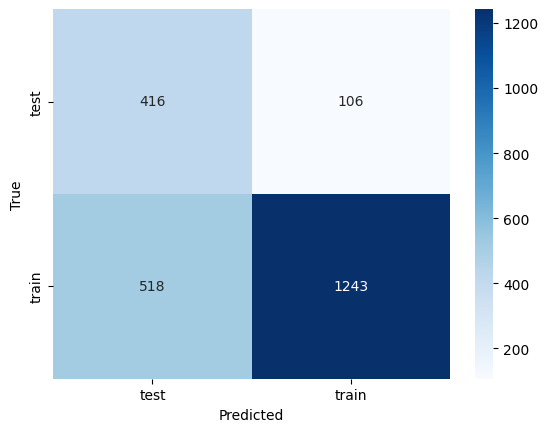

c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Administrator\Documents\Projects\Covid\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGEN

Training resnet on bilateral dataset
Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
## Evaluar Modelo
for dataset in ['bilateral', 'raw', 'canny']:
    print(f'Evaluating {model_name} on {dataset} dataset')
    evaluate_model(model, dataloaders, dataset_sizes)


# Cargar y ajustar los modelos
models_to_train = {
    'resnet': models.resnet18(pretrained=True),
    'vgg': models.vgg16(pretrained=True)
}

for model_name, model in models_to_train.items():
    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'resnet':
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    elif model_name == 'vgg':
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters() if model_name == 'resnet' else model.classifier[6].parameters(), lr=0.001, momentum=0.9)

    for dataset in ['bilateral', 'raw', 'canny']:
        print(f'Training {model_name} on {dataset} dataset')
        model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes)
        torch.save(model.state_dict(), f'{model_name}_{dataset}.pth')
        evaluate_model(model, dataloaders, dataset_sizes)